##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TF Lite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TF Lite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## Select the TF2 SavedModel module to use

For starters, use https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4. The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

In [3]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

     8192/228813984 [..............................] - ETA: 4s

  5570560/228813984 [..............................] - ETA: 2s

  8396800/228813984 [>.............................] - ETA: 9s

 17481728/228813984 [=>............................] - ETA: 4s

 28499968/228813984 [==>...........................] - ETA: 3s

 36421632/228813984 [===>..........................] - ETA: 2s

 41951232/228813984 [====>.........................] - ETA: 3s

 53411840/228813984 [======>.......................] - ETA: 2s

 62070784/228813984 [=======>......................] - ETA: 2s

 70828032/228813984 [========>.....................] - ETA: 1s

 75505664/228813984 [========>.....................] - ETA: 2s

 83894272/228813984 [=========>....................] - ETA: 2s

 94961664/228813984 [===========>..................] - ETA: 1s

100671488/228813984 [============>.................] - ETA: 2s

109682688/228813984 [=============>................] - ETA: 2s

121061376/228813984 [==============>...............] - ETA: 2s

133332992/228813984 [================>.............] - ETA: 1s

134225920/228813984 [================>.............] - ETA: 1s

142614528/228813984 [=================>............] - ETA: 1s

153165824/228813984 [===================>..........] - ETA: 1s

165453824/228813984 [====================>.........] - ETA: 1s

167780352/228813984 [====================>.........] - ETA: 1s

177594368/228813984 [======================>.......] - ETA: 0s

184557568/228813984 [=======================>......] - ETA: 0s

195133440/228813984 [========================>.....] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

212033536/228813984 [==========================>...] - ETA: 0s

224436224/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 4s 0us/step


In [5]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5


 1/91 [..............................] - ETA: 0s - loss: 2.2211 - accuracy: 0.0938

 3/91 [..............................] - ETA: 4s - loss: 2.1014 - accuracy: 0.1771

 4/91 [>.............................] - ETA: 6s - loss: 2.0159 - accuracy: 0.1641

 5/91 [>.............................] - ETA: 7s - loss: 1.9068 - accuracy: 0.2062

 6/91 [>.............................] - ETA: 7s - loss: 1.8406 - accuracy: 0.2083

 7/91 [=>............................] - ETA: 8s - loss: 1.7949 - accuracy: 0.2411

 8/91 [=>............................] - ETA: 8s - loss: 1.7626 - accuracy: 0.2656

 9/91 [=>............................] - ETA: 8s - loss: 1.7132 - accuracy: 0.2847

10/91 [==>...........................] - ETA: 8s - loss: 1.6726 - accuracy: 0.3063

11/91 [==>...........................] - ETA: 8s - loss: 1.6383 - accuracy: 0.3295

12/91 [==>...........................] - ETA: 8s - loss: 1.5982 - accuracy: 0.3490

13/91 [===>..........................] - ETA: 8s - loss: 1.5641 - accuracy: 0.3702

14/91 [===>..........................] - ETA: 8s - loss: 1.5235 - accuracy: 0.3884

15/91 [===>..........................] - ETA: 8s - loss: 1.4935 - accuracy: 0.4062

16/91 [====>.........................] - ETA: 8s - loss: 1.4740 - accuracy: 0.4238

17/91 [====>.........................] - ETA: 8s - loss: 1.4573 - accuracy: 0.4357

18/91 [====>.........................] - ETA: 8s - loss: 1.4285 - accuracy: 0.4514

19/91 [=====>........................] - ETA: 8s - loss: 1.4047 - accuracy: 0.4671

20/91 [=====>........................] - ETA: 8s - loss: 1.3767 - accuracy: 0.4828

21/91 [=====>........................] - ETA: 8s - loss: 1.3509 - accuracy: 0.4970

22/91 [======>.......................] - ETA: 8s - loss: 1.3309 - accuracy: 0.5085

23/91 [======>.......................] - ETA: 8s - loss: 1.3195 - accuracy: 0.5149

24/91 [======>.......................] - ETA: 8s - loss: 1.3025 - accuracy: 0.5247

25/91 [=======>......................] - ETA: 8s - loss: 1.2881 - accuracy: 0.5337

26/91 [=======>......................] - ETA: 7s - loss: 1.2685 - accuracy: 0.5433

27/91 [=======>......................] - ETA: 7s - loss: 1.2647 - accuracy: 0.5486

28/91 [========>.....................] - ETA: 7s - loss: 1.2523 - accuracy: 0.5558

29/91 [========>.....................] - ETA: 7s - loss: 1.2409 - accuracy: 0.5636

30/91 [========>.....................] - ETA: 7s - loss: 1.2287 - accuracy: 0.5719

31/91 [=========>....................] - ETA: 7s - loss: 1.2156 - accuracy: 0.5776

32/91 [=========>....................] - ETA: 7s - loss: 1.1998 - accuracy: 0.5879

33/91 [=========>....................] - ETA: 7s - loss: 1.1933 - accuracy: 0.5928

34/91 [==========>...................] - ETA: 6s - loss: 1.1815 - accuracy: 0.6011

35/91 [==========>...................] - ETA: 6s - loss: 1.1743 - accuracy: 0.6080

36/91 [==========>...................] - ETA: 6s - loss: 1.1655 - accuracy: 0.6128

37/91 [===========>..................] - ETA: 6s - loss: 1.1647 - accuracy: 0.6157

38/91 [===========>..................] - ETA: 6s - loss: 1.1577 - accuracy: 0.6192

39/91 [===========>..................] - ETA: 6s - loss: 1.1483 - accuracy: 0.6266

40/91 [============>.................] - ETA: 6s - loss: 1.1363 - accuracy: 0.6336

41/91 [============>.................] - ETA: 6s - loss: 1.1281 - accuracy: 0.6373

43/91 [=============>................] - ETA: 5s - loss: 1.1078 - accuracy: 0.6506

44/91 [=============>................] - ETA: 5s - loss: 1.1004 - accuracy: 0.6565

45/91 [=============>................] - ETA: 5s - loss: 1.0956 - accuracy: 0.6592

46/91 [==============>...............] - ETA: 5s - loss: 1.0902 - accuracy: 0.6633

47/91 [==============>...............] - ETA: 5s - loss: 1.0818 - accuracy: 0.6684

48/91 [==============>...............] - ETA: 5s - loss: 1.0784 - accuracy: 0.6715

49/91 [===============>..............] - ETA: 5s - loss: 1.0691 - accuracy: 0.6769

50/91 [===============>..............] - ETA: 5s - loss: 1.0628 - accuracy: 0.6815

51/91 [===============>..............] - ETA: 4s - loss: 1.0560 - accuracy: 0.6853

52/91 [================>.............] - ETA: 4s - loss: 1.0513 - accuracy: 0.6866

53/91 [================>.............] - ETA: 4s - loss: 1.0489 - accuracy: 0.6889

54/91 [================>.............] - ETA: 4s - loss: 1.0418 - accuracy: 0.6924

55/91 [=================>............] - ETA: 4s - loss: 1.0352 - accuracy: 0.6957

56/91 [=================>............] - ETA: 4s - loss: 1.0309 - accuracy: 0.6989

57/91 [=================>............] - ETA: 4s - loss: 1.0304 - accuracy: 0.6998

58/91 [==================>...........] - ETA: 4s - loss: 1.0286 - accuracy: 0.7002

59/91 [==================>...........] - ETA: 3s - loss: 1.0229 - accuracy: 0.7042

60/91 [==================>...........] - ETA: 3s - loss: 1.0178 - accuracy: 0.7081

61/91 [===================>..........] - ETA: 3s - loss: 1.0150 - accuracy: 0.7098

62/91 [===================>..........] - ETA: 3s - loss: 1.0092 - accuracy: 0.7130

63/91 [===================>..........] - ETA: 3s - loss: 1.0052 - accuracy: 0.7156

64/91 [====================>.........] - ETA: 3s - loss: 1.0019 - accuracy: 0.7171

65/91 [====================>.........] - ETA: 3s - loss: 1.0008 - accuracy: 0.7181

66/91 [====================>.........] - ETA: 3s - loss: 0.9972 - accuracy: 0.7200

67/91 [=====================>........] - ETA: 2s - loss: 0.9953 - accuracy: 0.7209

68/91 [=====================>........] - ETA: 2s - loss: 0.9912 - accuracy: 0.7232

69/91 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.7249

70/91 [======================>.......] - ETA: 2s - loss: 0.9857 - accuracy: 0.7257

71/91 [======================>.......] - ETA: 2s - loss: 0.9813 - accuracy: 0.7278

72/91 [======================>.......] - ETA: 2s - loss: 0.9790 - accuracy: 0.7286

73/91 [=======================>......] - ETA: 2s - loss: 0.9756 - accuracy: 0.7310

74/91 [=======================>......] - ETA: 2s - loss: 0.9712 - accuracy: 0.7334

75/91 [=======================>......] - ETA: 1s - loss: 0.9692 - accuracy: 0.7349

76/91 [========================>.....] - ETA: 1s - loss: 0.9686 - accuracy: 0.7359

77/91 [========================>.....] - ETA: 1s - loss: 0.9650 - accuracy: 0.7381

78/91 [========================>.....] - ETA: 1s - loss: 0.9627 - accuracy: 0.7395

79/91 [=========================>....] - ETA: 1s - loss: 0.9607 - accuracy: 0.7404

80/91 [=========================>....] - ETA: 1s - loss: 0.9598 - accuracy: 0.7409

81/91 [=========================>....] - ETA: 1s - loss: 0.9553 - accuracy: 0.7433

82/91 [==========================>...] - ETA: 1s - loss: 0.9529 - accuracy: 0.7438

83/91 [==========================>...] - ETA: 0s - loss: 0.9527 - accuracy: 0.7435

84/91 [==========================>...] - ETA: 0s - loss: 0.9498 - accuracy: 0.7451

85/91 [===========================>..] - ETA: 0s - loss: 0.9455 - accuracy: 0.7477

86/91 [===========================>..] - ETA: 0s - loss: 0.9424 - accuracy: 0.7492

87/91 [===========================>..] - ETA: 0s - loss: 0.9418 - accuracy: 0.7496

88/91 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.7503

89/91 [============================>.] - ETA: 0s - loss: 0.9376 - accuracy: 0.7513

90/91 [============================>.] - ETA: 0s - loss: 0.9374 - accuracy: 0.7520

91/91 [==============================] - ETA: 0s - loss: 0.9333 - accuracy: 0.7544

91/91 [==============================] - 15s 165ms/step - loss: 0.9333 - accuracy: 0.7544 - val_loss: 0.7685 - val_accuracy: 0.8239


Epoch 2/5
 1/91 [..............................] - ETA: 0s - loss: 0.8218 - accuracy: 0.7812

 2/91 [..............................] - ETA: 5s - loss: 0.8058 - accuracy: 0.8438

 3/91 [..............................] - ETA: 7s - loss: 0.7489 - accuracy: 0.8542

 4/91 [>.............................] - ETA: 8s - loss: 0.7375 - accuracy: 0.8672

 5/91 [>.............................] - ETA: 8s - loss: 0.7055 - accuracy: 0.8813

 6/91 [>.............................] - ETA: 8s - loss: 0.7333 - accuracy: 0.8594

 7/91 [=>............................] - ETA: 8s - loss: 0.7289 - accuracy: 0.8616

 8/91 [=>............................] - ETA: 9s - loss: 0.7262 - accuracy: 0.8672

 9/91 [=>............................] - ETA: 9s - loss: 0.7402 - accuracy: 0.8611

10/91 [==>...........................] - ETA: 9s - loss: 0.7239 - accuracy: 0.8719

11/91 [==>...........................] - ETA: 8s - loss: 0.7199 - accuracy: 0.8750

12/91 [==>...........................] - ETA: 9s - loss: 0.7298 - accuracy: 0.8672

13/91 [===>..........................] - ETA: 9s - loss: 0.7305 - accuracy: 0.8654

14/91 [===>..........................] - ETA: 9s - loss: 0.7306 - accuracy: 0.8661

15/91 [===>..........................] - ETA: 9s - loss: 0.7339 - accuracy: 0.8604

16/91 [====>.........................] - ETA: 8s - loss: 0.7302 - accuracy: 0.8613

17/91 [====>.........................] - ETA: 8s - loss: 0.7243 - accuracy: 0.8621

18/91 [====>.........................] - ETA: 8s - loss: 0.7174 - accuracy: 0.8663

19/91 [=====>........................] - ETA: 8s - loss: 0.7134 - accuracy: 0.8701

20/91 [=====>........................] - ETA: 8s - loss: 0.7157 - accuracy: 0.8672

21/91 [=====>........................] - ETA: 8s - loss: 0.7191 - accuracy: 0.8676

22/91 [======>.......................] - ETA: 8s - loss: 0.7155 - accuracy: 0.8707

23/91 [======>.......................] - ETA: 8s - loss: 0.7151 - accuracy: 0.8696

24/91 [======>.......................] - ETA: 8s - loss: 0.7086 - accuracy: 0.8737

25/91 [=======>......................] - ETA: 8s - loss: 0.7088 - accuracy: 0.8725

26/91 [=======>......................] - ETA: 7s - loss: 0.7056 - accuracy: 0.8762

27/91 [=======>......................] - ETA: 7s - loss: 0.7052 - accuracy: 0.8773

28/91 [========>.....................] - ETA: 7s - loss: 0.7030 - accuracy: 0.8783

29/91 [========>.....................] - ETA: 7s - loss: 0.7021 - accuracy: 0.8782

30/91 [========>.....................] - ETA: 7s - loss: 0.7012 - accuracy: 0.8792

31/91 [=========>....................] - ETA: 7s - loss: 0.6994 - accuracy: 0.8790

32/91 [=========>....................] - ETA: 7s - loss: 0.7018 - accuracy: 0.8770

33/91 [=========>....................] - ETA: 7s - loss: 0.7010 - accuracy: 0.8769

34/91 [==========>...................] - ETA: 6s - loss: 0.7008 - accuracy: 0.8759

35/91 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.8786

36/91 [==========>...................] - ETA: 6s - loss: 0.6954 - accuracy: 0.8785

37/91 [===========>..................] - ETA: 6s - loss: 0.6951 - accuracy: 0.8775

38/91 [===========>..................] - ETA: 6s - loss: 0.6934 - accuracy: 0.8775

39/91 [===========>..................] - ETA: 6s - loss: 0.6943 - accuracy: 0.8766

40/91 [============>.................] - ETA: 6s - loss: 0.6912 - accuracy: 0.8789

41/91 [============>.................] - ETA: 6s - loss: 0.6937 - accuracy: 0.8761

42/91 [============>.................] - ETA: 6s - loss: 0.6924 - accuracy: 0.8760

43/91 [=============>................] - ETA: 5s - loss: 0.6930 - accuracy: 0.8760

44/91 [=============>................] - ETA: 5s - loss: 0.6932 - accuracy: 0.8753

45/91 [=============>................] - ETA: 5s - loss: 0.6944 - accuracy: 0.8746

46/91 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.8739

47/91 [==============>...............] - ETA: 5s - loss: 0.6940 - accuracy: 0.8753

48/91 [==============>...............] - ETA: 5s - loss: 0.6919 - accuracy: 0.8759

49/91 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.8746

50/91 [===============>..............] - ETA: 5s - loss: 0.6946 - accuracy: 0.8746

51/91 [===============>..............] - ETA: 4s - loss: 0.6947 - accuracy: 0.8740

52/91 [================>.............] - ETA: 4s - loss: 0.6931 - accuracy: 0.8758

53/91 [================>.............] - ETA: 4s - loss: 0.6925 - accuracy: 0.8764

54/91 [================>.............] - ETA: 4s - loss: 0.6917 - accuracy: 0.8758

55/91 [=================>............] - ETA: 4s - loss: 0.6927 - accuracy: 0.8741

56/91 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.8741

57/91 [=================>............] - ETA: 4s - loss: 0.6931 - accuracy: 0.8758

58/91 [==================>...........] - ETA: 4s - loss: 0.6925 - accuracy: 0.8768

59/91 [==================>...........] - ETA: 3s - loss: 0.6921 - accuracy: 0.8773

60/91 [==================>...........] - ETA: 3s - loss: 0.6903 - accuracy: 0.8783

61/91 [===================>..........] - ETA: 3s - loss: 0.6911 - accuracy: 0.8772

62/91 [===================>..........] - ETA: 3s - loss: 0.6908 - accuracy: 0.8767

63/91 [===================>..........] - ETA: 3s - loss: 0.6917 - accuracy: 0.8762

64/91 [====================>.........] - ETA: 3s - loss: 0.6936 - accuracy: 0.8752

65/91 [====================>.........] - ETA: 3s - loss: 0.6921 - accuracy: 0.8766

66/91 [====================>.........] - ETA: 3s - loss: 0.6918 - accuracy: 0.8761

67/91 [=====================>........] - ETA: 3s - loss: 0.6925 - accuracy: 0.8752

68/91 [=====================>........] - ETA: 2s - loss: 0.6919 - accuracy: 0.8752

69/91 [=====================>........] - ETA: 2s - loss: 0.6940 - accuracy: 0.8738

70/91 [======================>.......] - ETA: 2s - loss: 0.6954 - accuracy: 0.8734

71/91 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.8743

72/91 [======================>.......] - ETA: 2s - loss: 0.6931 - accuracy: 0.8752

73/91 [=======================>......] - ETA: 2s - loss: 0.6969 - accuracy: 0.8734

74/91 [=======================>......] - ETA: 2s - loss: 0.6980 - accuracy: 0.8722

75/91 [=======================>......] - ETA: 2s - loss: 0.6990 - accuracy: 0.8714

76/91 [========================>.....] - ETA: 1s - loss: 0.6982 - accuracy: 0.8719

77/91 [========================>.....] - ETA: 1s - loss: 0.6988 - accuracy: 0.8715

78/91 [========================>.....] - ETA: 1s - loss: 0.6974 - accuracy: 0.8723

79/91 [=========================>....] - ETA: 1s - loss: 0.6990 - accuracy: 0.8724

80/91 [=========================>....] - ETA: 1s - loss: 0.6997 - accuracy: 0.8720

81/91 [=========================>....] - ETA: 1s - loss: 0.7012 - accuracy: 0.8709

82/91 [==========================>...] - ETA: 1s - loss: 0.7016 - accuracy: 0.8713

83/91 [==========================>...] - ETA: 1s - loss: 0.7025 - accuracy: 0.8710

84/91 [==========================>...] - ETA: 0s - loss: 0.7018 - accuracy: 0.8714

85/91 [===========================>..] - ETA: 0s - loss: 0.7015 - accuracy: 0.8715

86/91 [===========================>..] - ETA: 0s - loss: 0.7017 - accuracy: 0.8708

87/91 [===========================>..] - ETA: 0s - loss: 0.7051 - accuracy: 0.8701

88/91 [============================>.] - ETA: 0s - loss: 0.7074 - accuracy: 0.8698

89/91 [============================>.] - ETA: 0s - loss: 0.7062 - accuracy: 0.8706

90/91 [============================>.] - ETA: 0s - loss: 0.7053 - accuracy: 0.8710

91/91 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.8720

91/91 [==============================] - 14s 158ms/step - loss: 0.7039 - accuracy: 0.8720 - val_loss: 0.7094 - val_accuracy: 0.8537


Epoch 3/5
 1/91 [..............................] - ETA: 0s - loss: 0.5426 - accuracy: 0.9375

 2/91 [..............................] - ETA: 5s - loss: 0.5408 - accuracy: 0.9375

 3/91 [..............................] - ETA: 7s - loss: 0.6007 - accuracy: 0.9271

 4/91 [>.............................] - ETA: 8s - loss: 0.6118 - accuracy: 0.9219

 5/91 [>.............................] - ETA: 8s - loss: 0.6169 - accuracy: 0.9187

 6/91 [>.............................] - ETA: 8s - loss: 0.6255 - accuracy: 0.9167

 7/91 [=>............................] - ETA: 9s - loss: 0.6315 - accuracy: 0.9152

 8/91 [=>............................] - ETA: 9s - loss: 0.6389 - accuracy: 0.9180

 9/91 [=>............................] - ETA: 9s - loss: 0.6419 - accuracy: 0.9167

10/91 [==>...........................] - ETA: 9s - loss: 0.6366 - accuracy: 0.9187

11/91 [==>...........................] - ETA: 9s - loss: 0.6399 - accuracy: 0.9205

12/91 [==>...........................] - ETA: 9s - loss: 0.6372 - accuracy: 0.9219

13/91 [===>..........................] - ETA: 9s - loss: 0.6300 - accuracy: 0.9231

14/91 [===>..........................] - ETA: 8s - loss: 0.6242 - accuracy: 0.9241

15/91 [===>..........................] - ETA: 8s - loss: 0.6270 - accuracy: 0.9229

16/91 [====>.........................] - ETA: 8s - loss: 0.6218 - accuracy: 0.9238

17/91 [====>.........................] - ETA: 8s - loss: 0.6231 - accuracy: 0.9191

18/91 [====>.........................] - ETA: 8s - loss: 0.6296 - accuracy: 0.9184

19/91 [=====>........................] - ETA: 8s - loss: 0.6272 - accuracy: 0.9211

20/91 [=====>........................] - ETA: 8s - loss: 0.6354 - accuracy: 0.9156

21/91 [=====>........................] - ETA: 8s - loss: 0.6318 - accuracy: 0.9182

22/91 [======>.......................] - ETA: 8s - loss: 0.6335 - accuracy: 0.9176

23/91 [======>.......................] - ETA: 8s - loss: 0.6346 - accuracy: 0.9152

24/91 [======>.......................] - ETA: 8s - loss: 0.6406 - accuracy: 0.9135

25/91 [=======>......................] - ETA: 7s - loss: 0.6451 - accuracy: 0.9094

26/91 [=======>......................] - ETA: 7s - loss: 0.6387 - accuracy: 0.9129

27/91 [=======>......................] - ETA: 7s - loss: 0.6402 - accuracy: 0.9115

28/91 [========>.....................] - ETA: 7s - loss: 0.6407 - accuracy: 0.9125

29/91 [========>.....................] - ETA: 7s - loss: 0.6402 - accuracy: 0.9133

30/91 [========>.....................] - ETA: 7s - loss: 0.6404 - accuracy: 0.9110

31/91 [=========>....................] - ETA: 7s - loss: 0.6409 - accuracy: 0.9108

32/91 [=========>....................] - ETA: 7s - loss: 0.6410 - accuracy: 0.9097

33/91 [=========>....................] - ETA: 7s - loss: 0.6379 - accuracy: 0.9115

34/91 [==========>...................] - ETA: 6s - loss: 0.6381 - accuracy: 0.9114

35/91 [==========>...................] - ETA: 6s - loss: 0.6403 - accuracy: 0.9103

36/91 [==========>...................] - ETA: 6s - loss: 0.6409 - accuracy: 0.9102

37/91 [===========>..................] - ETA: 6s - loss: 0.6441 - accuracy: 0.9067

38/91 [===========>..................] - ETA: 6s - loss: 0.6428 - accuracy: 0.9075

39/91 [===========>..................] - ETA: 6s - loss: 0.6414 - accuracy: 0.9091

40/91 [============>.................] - ETA: 6s - loss: 0.6390 - accuracy: 0.9106

41/91 [============>.................] - ETA: 6s - loss: 0.6362 - accuracy: 0.9120

42/91 [============>.................] - ETA: 6s - loss: 0.6363 - accuracy: 0.9111

43/91 [=============>................] - ETA: 5s - loss: 0.6374 - accuracy: 0.9110

44/91 [=============>................] - ETA: 5s - loss: 0.6354 - accuracy: 0.9123

45/91 [=============>................] - ETA: 5s - loss: 0.6349 - accuracy: 0.9122

46/91 [==============>...............] - ETA: 5s - loss: 0.6360 - accuracy: 0.9114

47/91 [==============>...............] - ETA: 5s - loss: 0.6350 - accuracy: 0.9119

48/91 [==============>...............] - ETA: 5s - loss: 0.6368 - accuracy: 0.9105

49/91 [===============>..............] - ETA: 5s - loss: 0.6356 - accuracy: 0.9111

50/91 [===============>..............] - ETA: 5s - loss: 0.6349 - accuracy: 0.9103

51/91 [===============>..............] - ETA: 4s - loss: 0.6361 - accuracy: 0.9084

52/91 [================>.............] - ETA: 4s - loss: 0.6362 - accuracy: 0.9078

53/91 [================>.............] - ETA: 4s - loss: 0.6375 - accuracy: 0.9060

54/91 [================>.............] - ETA: 4s - loss: 0.6347 - accuracy: 0.9071

55/91 [=================>............] - ETA: 4s - loss: 0.6328 - accuracy: 0.9083

56/91 [=================>............] - ETA: 4s - loss: 0.6360 - accuracy: 0.9060

57/91 [=================>............] - ETA: 4s - loss: 0.6356 - accuracy: 0.9065

58/91 [==================>...........] - ETA: 4s - loss: 0.6375 - accuracy: 0.9060

59/91 [==================>...........] - ETA: 3s - loss: 0.6372 - accuracy: 0.9055

60/91 [==================>...........] - ETA: 3s - loss: 0.6374 - accuracy: 0.9055

61/91 [===================>..........] - ETA: 3s - loss: 0.6384 - accuracy: 0.9045

62/91 [===================>..........] - ETA: 3s - loss: 0.6388 - accuracy: 0.9045

63/91 [===================>..........] - ETA: 3s - loss: 0.6369 - accuracy: 0.9050

64/91 [====================>.........] - ETA: 3s - loss: 0.6375 - accuracy: 0.9050

65/91 [====================>.........] - ETA: 3s - loss: 0.6395 - accuracy: 0.9036

66/91 [====================>.........] - ETA: 3s - loss: 0.6407 - accuracy: 0.9027

67/91 [=====================>........] - ETA: 2s - loss: 0.6421 - accuracy: 0.9018

68/91 [=====================>........] - ETA: 2s - loss: 0.6413 - accuracy: 0.9028

69/91 [=====================>........] - ETA: 2s - loss: 0.6423 - accuracy: 0.9024

70/91 [======================>.......] - ETA: 2s - loss: 0.6423 - accuracy: 0.9020

71/91 [======================>.......] - ETA: 2s - loss: 0.6426 - accuracy: 0.9016

72/91 [======================>.......] - ETA: 2s - loss: 0.6433 - accuracy: 0.9004

73/91 [=======================>......] - ETA: 2s - loss: 0.6427 - accuracy: 0.9009

74/91 [=======================>......] - ETA: 2s - loss: 0.6431 - accuracy: 0.9006

75/91 [=======================>......] - ETA: 1s - loss: 0.6422 - accuracy: 0.9006

76/91 [========================>.....] - ETA: 1s - loss: 0.6409 - accuracy: 0.9015

77/91 [========================>.....] - ETA: 1s - loss: 0.6410 - accuracy: 0.9016

78/91 [========================>.....] - ETA: 1s - loss: 0.6407 - accuracy: 0.9020

79/91 [=========================>....] - ETA: 1s - loss: 0.6404 - accuracy: 0.9025

80/91 [=========================>....] - ETA: 1s - loss: 0.6397 - accuracy: 0.9029

81/91 [=========================>....] - ETA: 1s - loss: 0.6406 - accuracy: 0.9030

82/91 [==========================>...] - ETA: 1s - loss: 0.6423 - accuracy: 0.9026

83/91 [==========================>...] - ETA: 0s - loss: 0.6446 - accuracy: 0.9015

84/91 [==========================>...] - ETA: 0s - loss: 0.6437 - accuracy: 0.9020

85/91 [===========================>..] - ETA: 0s - loss: 0.6454 - accuracy: 0.9013

86/91 [===========================>..] - ETA: 0s - loss: 0.6456 - accuracy: 0.9017

87/91 [===========================>..] - ETA: 0s - loss: 0.6447 - accuracy: 0.9021

88/91 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.9015

89/91 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.9026

90/91 [============================>.] - ETA: 0s - loss: 0.6445 - accuracy: 0.9023

91/91 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.9023

91/91 [==============================] - 14s 157ms/step - loss: 0.6443 - accuracy: 0.9023 - val_loss: 0.7079 - val_accuracy: 0.8565


Epoch 4/5
 1/91 [..............................] - ETA: 0s - loss: 0.6984 - accuracy: 0.9062

 2/91 [..............................] - ETA: 5s - loss: 0.6801 - accuracy: 0.9219

 3/91 [..............................] - ETA: 6s - loss: 0.6595 - accuracy: 0.9271

 4/91 [>.............................] - ETA: 7s - loss: 0.6637 - accuracy: 0.9141

 5/91 [>.............................] - ETA: 8s - loss: 0.6509 - accuracy: 0.9187

 6/91 [>.............................] - ETA: 8s - loss: 0.6503 - accuracy: 0.9167

 7/91 [=>............................] - ETA: 8s - loss: 0.6398 - accuracy: 0.9196

 8/91 [=>............................] - ETA: 8s - loss: 0.6319 - accuracy: 0.9180

 9/91 [=>............................] - ETA: 8s - loss: 0.6541 - accuracy: 0.9097

10/91 [==>...........................] - ETA: 8s - loss: 0.6394 - accuracy: 0.9156

11/91 [==>...........................] - ETA: 8s - loss: 0.6383 - accuracy: 0.9176

12/91 [==>...........................] - ETA: 8s - loss: 0.6386 - accuracy: 0.9115

13/91 [===>..........................] - ETA: 8s - loss: 0.6399 - accuracy: 0.9111

14/91 [===>..........................] - ETA: 8s - loss: 0.6427 - accuracy: 0.9085

15/91 [===>..........................] - ETA: 8s - loss: 0.6357 - accuracy: 0.9125

16/91 [====>.........................] - ETA: 8s - loss: 0.6305 - accuracy: 0.9121

17/91 [====>.........................] - ETA: 8s - loss: 0.6356 - accuracy: 0.9099

18/91 [====>.........................] - ETA: 8s - loss: 0.6297 - accuracy: 0.9132

19/91 [=====>........................] - ETA: 8s - loss: 0.6293 - accuracy: 0.9112

20/91 [=====>........................] - ETA: 8s - loss: 0.6242 - accuracy: 0.9156

21/91 [=====>........................] - ETA: 8s - loss: 0.6251 - accuracy: 0.9182

22/91 [======>.......................] - ETA: 8s - loss: 0.6234 - accuracy: 0.9190

23/91 [======>.......................] - ETA: 8s - loss: 0.6234 - accuracy: 0.9212

24/91 [======>.......................] - ETA: 7s - loss: 0.6258 - accuracy: 0.9187

25/91 [=======>......................] - ETA: 7s - loss: 0.6205 - accuracy: 0.9220

26/91 [=======>......................] - ETA: 7s - loss: 0.6207 - accuracy: 0.9214

27/91 [=======>......................] - ETA: 7s - loss: 0.6208 - accuracy: 0.9232

28/91 [========>.....................] - ETA: 7s - loss: 0.6206 - accuracy: 0.9226

29/91 [========>.....................] - ETA: 7s - loss: 0.6207 - accuracy: 0.9231

30/91 [========>.....................] - ETA: 7s - loss: 0.6189 - accuracy: 0.9246

31/91 [=========>....................] - ETA: 7s - loss: 0.6172 - accuracy: 0.9260

32/91 [=========>....................] - ETA: 7s - loss: 0.6167 - accuracy: 0.9254

33/91 [=========>....................] - ETA: 7s - loss: 0.6188 - accuracy: 0.9229

34/91 [==========>...................] - ETA: 6s - loss: 0.6202 - accuracy: 0.9215

35/91 [==========>...................] - ETA: 6s - loss: 0.6169 - accuracy: 0.9229

36/91 [==========>...................] - ETA: 6s - loss: 0.6151 - accuracy: 0.9233

37/91 [===========>..................] - ETA: 6s - loss: 0.6141 - accuracy: 0.9237

38/91 [===========>..................] - ETA: 6s - loss: 0.6133 - accuracy: 0.9240

39/91 [===========>..................] - ETA: 6s - loss: 0.6126 - accuracy: 0.9252

40/91 [============>.................] - ETA: 6s - loss: 0.6114 - accuracy: 0.9263

41/91 [============>.................] - ETA: 6s - loss: 0.6125 - accuracy: 0.9250

42/91 [============>.................] - ETA: 6s - loss: 0.6123 - accuracy: 0.9253

43/91 [=============>................] - ETA: 5s - loss: 0.6124 - accuracy: 0.9241

44/91 [=============>................] - ETA: 5s - loss: 0.6112 - accuracy: 0.9252

45/91 [=============>................] - ETA: 5s - loss: 0.6122 - accuracy: 0.9233

46/91 [==============>...............] - ETA: 5s - loss: 0.6123 - accuracy: 0.9230

47/91 [==============>...............] - ETA: 5s - loss: 0.6120 - accuracy: 0.9226

48/91 [==============>...............] - ETA: 5s - loss: 0.6123 - accuracy: 0.9216

49/91 [===============>..............] - ETA: 5s - loss: 0.6146 - accuracy: 0.9207

50/91 [===============>..............] - ETA: 5s - loss: 0.6151 - accuracy: 0.9204

51/91 [===============>..............] - ETA: 4s - loss: 0.6155 - accuracy: 0.9189

52/91 [================>.............] - ETA: 4s - loss: 0.6162 - accuracy: 0.9180

53/91 [================>.............] - ETA: 4s - loss: 0.6170 - accuracy: 0.9172

54/91 [================>.............] - ETA: 4s - loss: 0.6181 - accuracy: 0.9176

55/91 [=================>............] - ETA: 4s - loss: 0.6211 - accuracy: 0.9174

56/91 [=================>............] - ETA: 4s - loss: 0.6198 - accuracy: 0.9177

57/91 [=================>............] - ETA: 4s - loss: 0.6199 - accuracy: 0.9175

58/91 [==================>...........] - ETA: 4s - loss: 0.6188 - accuracy: 0.9184

59/91 [==================>...........] - ETA: 3s - loss: 0.6185 - accuracy: 0.9182

60/91 [==================>...........] - ETA: 3s - loss: 0.6189 - accuracy: 0.9185

61/91 [===================>..........] - ETA: 3s - loss: 0.6176 - accuracy: 0.9194

62/91 [===================>..........] - ETA: 3s - loss: 0.6175 - accuracy: 0.9192

63/91 [===================>..........] - ETA: 3s - loss: 0.6173 - accuracy: 0.9184

64/91 [====================>.........] - ETA: 3s - loss: 0.6171 - accuracy: 0.9173

65/91 [====================>.........] - ETA: 3s - loss: 0.6173 - accuracy: 0.9171

66/91 [====================>.........] - ETA: 3s - loss: 0.6176 - accuracy: 0.9169

67/91 [=====================>........] - ETA: 2s - loss: 0.6173 - accuracy: 0.9177

68/91 [=====================>........] - ETA: 2s - loss: 0.6174 - accuracy: 0.9175

69/91 [=====================>........] - ETA: 2s - loss: 0.6170 - accuracy: 0.9183

70/91 [======================>.......] - ETA: 2s - loss: 0.6164 - accuracy: 0.9190

71/91 [======================>.......] - ETA: 2s - loss: 0.6163 - accuracy: 0.9193

72/91 [======================>.......] - ETA: 2s - loss: 0.6156 - accuracy: 0.9200

73/91 [=======================>......] - ETA: 2s - loss: 0.6147 - accuracy: 0.9206

74/91 [=======================>......] - ETA: 2s - loss: 0.6153 - accuracy: 0.9200

75/91 [=======================>......] - ETA: 1s - loss: 0.6147 - accuracy: 0.9207

76/91 [========================>.....] - ETA: 1s - loss: 0.6167 - accuracy: 0.9197

77/91 [========================>.....] - ETA: 1s - loss: 0.6178 - accuracy: 0.9191

78/91 [========================>.....] - ETA: 1s - loss: 0.6176 - accuracy: 0.9197

79/91 [=========================>....] - ETA: 1s - loss: 0.6179 - accuracy: 0.9195

80/91 [=========================>....] - ETA: 1s - loss: 0.6190 - accuracy: 0.9194

81/91 [=========================>....] - ETA: 1s - loss: 0.6208 - accuracy: 0.9188

82/91 [==========================>...] - ETA: 1s - loss: 0.6209 - accuracy: 0.9191

83/91 [==========================>...] - ETA: 0s - loss: 0.6197 - accuracy: 0.9197

84/91 [==========================>...] - ETA: 0s - loss: 0.6195 - accuracy: 0.9187

85/91 [===========================>..] - ETA: 0s - loss: 0.6207 - accuracy: 0.9186

86/91 [===========================>..] - ETA: 0s - loss: 0.6215 - accuracy: 0.9177

87/91 [===========================>..] - ETA: 0s - loss: 0.6217 - accuracy: 0.9176

88/91 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.9175

89/91 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.9170

90/91 [============================>.] - ETA: 0s - loss: 0.6213 - accuracy: 0.9165

91/91 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.9168

91/91 [==============================] - 14s 158ms/step - loss: 0.6212 - accuracy: 0.9168 - val_loss: 0.7030 - val_accuracy: 0.8537


Epoch 5/5
 1/91 [..............................] - ETA: 0s - loss: 0.6294 - accuracy: 0.9062

 2/91 [..............................] - ETA: 5s - loss: 0.6503 - accuracy: 0.8906

 3/91 [..............................] - ETA: 7s - loss: 0.6293 - accuracy: 0.9062

 4/91 [>.............................] - ETA: 8s - loss: 0.6068 - accuracy: 0.9219

 5/91 [>.............................] - ETA: 8s - loss: 0.6031 - accuracy: 0.9187

 6/91 [>.............................] - ETA: 8s - loss: 0.6237 - accuracy: 0.9115

 7/91 [=>............................] - ETA: 9s - loss: 0.6276 - accuracy: 0.9196

 8/91 [=>............................] - ETA: 9s - loss: 0.6294 - accuracy: 0.9180

 9/91 [=>............................] - ETA: 9s - loss: 0.6408 - accuracy: 0.9132

10/91 [==>...........................] - ETA: 9s - loss: 0.6377 - accuracy: 0.9125

11/91 [==>...........................] - ETA: 9s - loss: 0.6339 - accuracy: 0.9148

12/91 [==>...........................] - ETA: 9s - loss: 0.6433 - accuracy: 0.9141

13/91 [===>..........................] - ETA: 9s - loss: 0.6348 - accuracy: 0.9183

14/91 [===>..........................] - ETA: 8s - loss: 0.6308 - accuracy: 0.9196

15/91 [===>..........................] - ETA: 8s - loss: 0.6294 - accuracy: 0.9208

16/91 [====>.........................] - ETA: 8s - loss: 0.6295 - accuracy: 0.9160

17/91 [====>.........................] - ETA: 8s - loss: 0.6248 - accuracy: 0.9210

18/91 [====>.........................] - ETA: 8s - loss: 0.6257 - accuracy: 0.9201

19/91 [=====>........................] - ETA: 8s - loss: 0.6240 - accuracy: 0.9211

20/91 [=====>........................] - ETA: 8s - loss: 0.6229 - accuracy: 0.9219

21/91 [=====>........................] - ETA: 8s - loss: 0.6188 - accuracy: 0.9256

22/91 [======>.......................] - ETA: 8s - loss: 0.6264 - accuracy: 0.9205

23/91 [======>.......................] - ETA: 8s - loss: 0.6272 - accuracy: 0.9212

24/91 [======>.......................] - ETA: 8s - loss: 0.6263 - accuracy: 0.9219

25/91 [=======>......................] - ETA: 7s - loss: 0.6264 - accuracy: 0.9225

26/91 [=======>......................] - ETA: 7s - loss: 0.6215 - accuracy: 0.9255

27/91 [=======>......................] - ETA: 7s - loss: 0.6227 - accuracy: 0.9259

28/91 [========>.....................] - ETA: 7s - loss: 0.6198 - accuracy: 0.9263

29/91 [========>.....................] - ETA: 7s - loss: 0.6198 - accuracy: 0.9256

30/91 [========>.....................] - ETA: 7s - loss: 0.6165 - accuracy: 0.9271

31/91 [=========>....................] - ETA: 7s - loss: 0.6169 - accuracy: 0.9264

32/91 [=========>....................] - ETA: 7s - loss: 0.6178 - accuracy: 0.9258

33/91 [=========>....................] - ETA: 7s - loss: 0.6168 - accuracy: 0.9261

34/91 [==========>...................] - ETA: 6s - loss: 0.6154 - accuracy: 0.9265

35/91 [==========>...................] - ETA: 6s - loss: 0.6174 - accuracy: 0.9259

36/91 [==========>...................] - ETA: 6s - loss: 0.6163 - accuracy: 0.9271

37/91 [===========>..................] - ETA: 6s - loss: 0.6137 - accuracy: 0.9282

38/91 [===========>..................] - ETA: 6s - loss: 0.6118 - accuracy: 0.9285

39/91 [===========>..................] - ETA: 6s - loss: 0.6106 - accuracy: 0.9287

40/91 [============>.................] - ETA: 6s - loss: 0.6140 - accuracy: 0.9273

41/91 [============>.................] - ETA: 6s - loss: 0.6122 - accuracy: 0.9276

42/91 [============>.................] - ETA: 6s - loss: 0.6112 - accuracy: 0.9278

43/91 [=============>................] - ETA: 5s - loss: 0.6115 - accuracy: 0.9266

44/91 [=============>................] - ETA: 5s - loss: 0.6094 - accuracy: 0.9268

45/91 [=============>................] - ETA: 5s - loss: 0.6125 - accuracy: 0.9250

46/91 [==============>...............] - ETA: 5s - loss: 0.6117 - accuracy: 0.9253

47/91 [==============>...............] - ETA: 5s - loss: 0.6120 - accuracy: 0.9262

48/91 [==============>...............] - ETA: 5s - loss: 0.6106 - accuracy: 0.9271

49/91 [===============>..............] - ETA: 5s - loss: 0.6099 - accuracy: 0.9267

50/91 [===============>..............] - ETA: 5s - loss: 0.6091 - accuracy: 0.9275

51/91 [===============>..............] - ETA: 4s - loss: 0.6084 - accuracy: 0.9283

52/91 [================>.............] - ETA: 4s - loss: 0.6080 - accuracy: 0.9285

53/91 [================>.............] - ETA: 4s - loss: 0.6072 - accuracy: 0.9292

54/91 [================>.............] - ETA: 4s - loss: 0.6058 - accuracy: 0.9300

55/91 [=================>............] - ETA: 4s - loss: 0.6051 - accuracy: 0.9301

56/91 [=================>............] - ETA: 4s - loss: 0.6035 - accuracy: 0.9308

57/91 [=================>............] - ETA: 4s - loss: 0.6043 - accuracy: 0.9309

58/91 [==================>...........] - ETA: 4s - loss: 0.6053 - accuracy: 0.9310

59/91 [==================>...........] - ETA: 3s - loss: 0.6045 - accuracy: 0.9311

60/91 [==================>...........] - ETA: 3s - loss: 0.6033 - accuracy: 0.9318

61/91 [===================>..........] - ETA: 3s - loss: 0.6031 - accuracy: 0.9314

62/91 [===================>..........] - ETA: 3s - loss: 0.6033 - accuracy: 0.9308

63/91 [===================>..........] - ETA: 3s - loss: 0.6027 - accuracy: 0.9309

64/91 [====================>.........] - ETA: 3s - loss: 0.6035 - accuracy: 0.9305

65/91 [====================>.........] - ETA: 3s - loss: 0.6041 - accuracy: 0.9296

66/91 [====================>.........] - ETA: 3s - loss: 0.6033 - accuracy: 0.9302

67/91 [=====================>........] - ETA: 2s - loss: 0.6021 - accuracy: 0.9308

68/91 [=====================>........] - ETA: 2s - loss: 0.6046 - accuracy: 0.9291

69/91 [=====================>........] - ETA: 2s - loss: 0.6041 - accuracy: 0.9296

70/91 [======================>.......] - ETA: 2s - loss: 0.6030 - accuracy: 0.9302

71/91 [======================>.......] - ETA: 2s - loss: 0.6031 - accuracy: 0.9299

72/91 [======================>.......] - ETA: 2s - loss: 0.6024 - accuracy: 0.9304

73/91 [=======================>......] - ETA: 2s - loss: 0.6029 - accuracy: 0.9301

74/91 [=======================>......] - ETA: 2s - loss: 0.6024 - accuracy: 0.9302

75/91 [=======================>......] - ETA: 1s - loss: 0.6028 - accuracy: 0.9290

76/91 [========================>.....] - ETA: 1s - loss: 0.6024 - accuracy: 0.9295

77/91 [========================>.....] - ETA: 1s - loss: 0.6038 - accuracy: 0.9280

78/91 [========================>.....] - ETA: 1s - loss: 0.6038 - accuracy: 0.9277

79/91 [=========================>....] - ETA: 1s - loss: 0.6034 - accuracy: 0.9275

80/91 [=========================>....] - ETA: 1s - loss: 0.6037 - accuracy: 0.9272

81/91 [=========================>....] - ETA: 1s - loss: 0.6034 - accuracy: 0.9273

82/91 [==========================>...] - ETA: 1s - loss: 0.6036 - accuracy: 0.9278

83/91 [==========================>...] - ETA: 0s - loss: 0.6032 - accuracy: 0.9287

84/91 [==========================>...] - ETA: 0s - loss: 0.6044 - accuracy: 0.9284

85/91 [===========================>..] - ETA: 0s - loss: 0.6037 - accuracy: 0.9293

86/91 [===========================>..] - ETA: 0s - loss: 0.6043 - accuracy: 0.9294

87/91 [===========================>..] - ETA: 0s - loss: 0.6052 - accuracy: 0.9288

88/91 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.9292

89/91 [============================>.] - ETA: 0s - loss: 0.6047 - accuracy: 0.9286

90/91 [============================>.] - ETA: 0s - loss: 0.6047 - accuracy: 0.9283

91/91 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.9278

91/91 [==============================] - 14s 156ms/step - loss: 0.6051 - accuracy: 0.9278 - val_loss: 0.6684 - val_accuracy: 0.8864


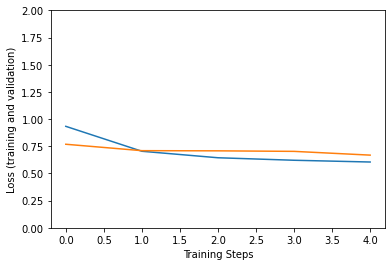

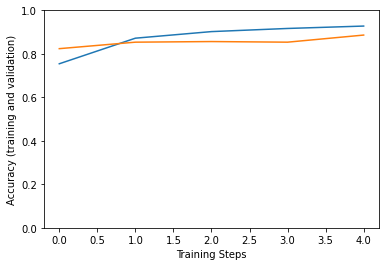

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Finally, the trained model can be saved for deployment to TF Serving or TF Lite (on mobile) as follows.

In [11]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.

In [0]:
#@title Optimization settings
# docs_infra: no_execute
# TODO(b/156102192)
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_generator for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open("/tmp/lite_flowers_model", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [0]:
# docs_infra: no_execute
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [0]:
#@markdown For rapid experimentation, start with a moderate number of examples.
# docs_infra: no_execute
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_generator
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))